<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/Circles_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Standard PyTorch imports
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [30]:
# If on MacBook:
if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available
    
print(device)

mps


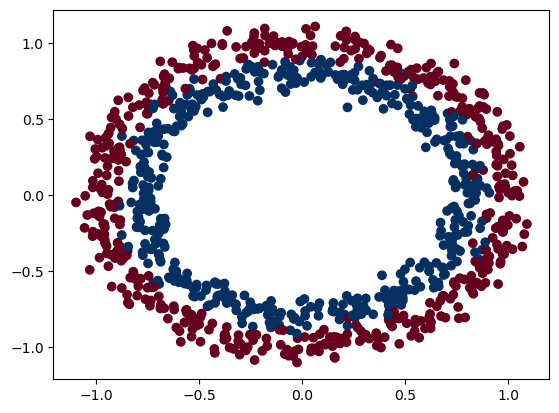

In [47]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.06,
    random_state=27,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [48]:
# Convert to tensors and split into train and test sets

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27
    )

X_train[:5], y_train[:5]

(tensor([[ 0.2535, -0.8022],
         [-0.7691,  0.2168],
         [-0.1825,  1.0957],
         [-0.4680, -0.6247],
         [ 0.8471,  0.0910]]),
 tensor([1., 1., 0., 1., 1.]))

In [6]:
from torch import nn

In [49]:
# 2. Define the PyTorch model
class CircleModel(nn.Module):
    def __init__(self):
        super(CircleModel, self).__init__()
        self.layer_1 = nn.Linear(2, 16)  # Input: 2 features, Output: 10 features
        self.layer_2 = nn.Linear(16, 8)  # Input: 10 features, Output: 10 features
        self.out = nn.Linear(8, 1)      # Input: 10 features, Output: 1 (binary classification)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x)) # Inserts ReLU after layer1
        x = self.relu(self.layer_2(x)) # Inserts ReLU after layer2
        x = self.out(x)  # No activation here because we'll use BCEWithLogitsLoss
        return x

In [50]:
model = CircleModel().to(device)
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

In [51]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(
    model.parameters()
    , lr=0.1)

In [40]:
# Since PyTorch has the nuances of 'device', sklearn code, while still doable, can be somewhat challenging because of this (e.g., have to write code into any sklearn methods to swtich / stich-back devices;) Hence, it might be more efficient to write a PyTorch compatible function for any sklearn code that presents these challenges;

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [41]:
from sklearn.metrics import accuracy_score

In [43]:
torch.manual_seed(27)

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1500 # Train for longer

# 'For epochs in a range'
for epoch in range(epochs):
  # 'Call model.train()'
    model.train()

    ### Training
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy *sklearn 'accuracy_score' (requires device mumbo jumbo) -or- 'accuracy_fn' (simpler)
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_score(y_true=y_train.detach().cpu(), y_pred=y_pred.detach().cpu()) * 100
#     acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_score(y_true=y_test.detach().cpu(), y_pred=test_pred.detach().cpu()) * 100
#         test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.67990, Accuracy: 54.50% | Test loss: 0.69214, Test acc: 44.00%
Epoch: 100 | Loss: 0.67372, Accuracy: 55.12% | Test loss: 0.68767, Test acc: 46.00%
Epoch: 200 | Loss: 0.66296, Accuracy: 60.25% | Test loss: 0.67736, Test acc: 52.00%
Epoch: 300 | Loss: 0.64650, Accuracy: 70.88% | Test loss: 0.66063, Test acc: 66.50%
Epoch: 400 | Loss: 0.61764, Accuracy: 78.12% | Test loss: 0.63173, Test acc: 73.00%
Epoch: 500 | Loss: 0.56236, Accuracy: 91.62% | Test loss: 0.57837, Test acc: 87.50%
Epoch: 600 | Loss: 0.46956, Accuracy: 96.12% | Test loss: 0.48798, Test acc: 92.50%
Epoch: 700 | Loss: 0.34465, Accuracy: 98.38% | Test loss: 0.36419, Test acc: 97.00%
Epoch: 800 | Loss: 0.22610, Accuracy: 99.50% | Test loss: 0.24691, Test acc: 99.00%
Epoch: 900 | Loss: 0.17134, Accuracy: 99.50% | Test loss: 0.18833, Test acc: 98.50%
Epoch: 1000 | Loss: 0.10016, Accuracy: 100.00% | Test loss: 0.11065, Test acc: 100.00%
Epoch: 1100 | Loss: 0.06785, Accuracy: 100.00% | Test loss: 0.07487, Test a

In [44]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()

y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([0., 0., 1., 1., 0., 0., 1., 0., 1., 1.], device='mps:0'),
 tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 1.]))

In [45]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


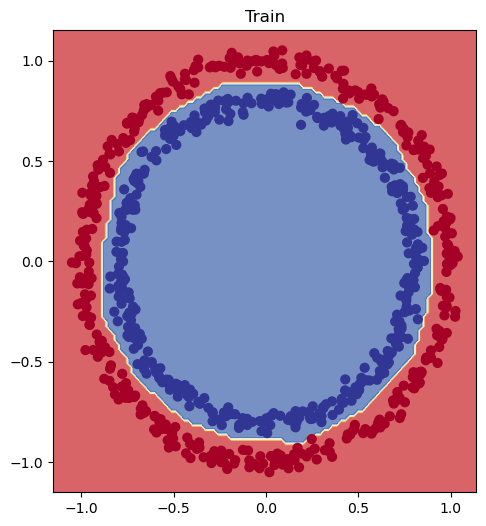

In [46]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train) 